# Learning and controlling a room's temperature
### By Farzad Vatandoust
### Email: vatandoustf@gamil.com
### GitHub: https://github.com/FarzadVatandoust

Table of content


# Introduction

The goal of this projects is to examine different ways to control a temperature of a room with a model predictive controller. This control method requires a surrogate model of the plant to predict the plant behavior in a near future which is typically called control horizon. The controller optimizes the controls input for the horizon and use the first prediction as the actual control input. Later, after acquiring the feedback from actual plant the controller shifts its horizon forward and does the same process again. The advantages of this method are that the controller adjust the its input based on the event in the future and the user can apply constraints on the controller inputs during the process. the figure blow represents a detailed schematic of the model predictive control.


![Model Predictive controll](./pic/pic1.png "Text to show on mouseover")

As you may understand, one of the most crucial parts of MPC is the plant's surrogate model. There are several methods for creating this twin model of the plant from a simple method like a linear approximation of the plant to a state-of-the-art method like deep learning. This project aims to identify a model for room’s temperature from temporal data with different methods and incorporate them in developing an MPC for controlling the room temperature.

 So, let's start analyzing our data.


## 1: Loading and analyzing the data

First we need to import the required libraries for data analysis and plotting 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv')
values = dataset.values
print(dataset.head())

                    time  room_temp  supply_temp  htg_setpoint  \
0  2021-04-26T09:37:00.0       72.3         59.3          68.5   
1  2021-04-26T09:38:00.0       72.2         58.8          68.5   
2  2021-04-26T09:39:00.0       72.2         58.5          68.5   
3  2021-04-26T09:40:00.0       72.1         58.2          68.5   
4  2021-04-26T09:41:00.0       71.9         58.1          68.5   

   airflow_current  htg_mode  
0              416     False  
1              413     False  
2              419     False  
3              410     False  
4              404     False  


We can see that our data consists of seven columns and every row represents a different time. Here the room temperature is the state of our system and the two control variable are the supply temperature and airflow current of the heater. The other parameters such as heater setpoint and heater mode are not useful for creating a surrogate model of our system so we will not use them anymore.

In [3]:
# drop unwanted data
del dataset['htg_setpoint']
del dataset['htg_mode']
print(dataset.head())

                    time  room_temp  supply_temp  airflow_current
0  2021-04-26T09:37:00.0       72.3         59.3              416
1  2021-04-26T09:38:00.0       72.2         58.8              413
2  2021-04-26T09:39:00.0       72.2         58.5              419
3  2021-04-26T09:40:00.0       72.1         58.2              410
4  2021-04-26T09:41:00.0       71.9         58.1              404


Lets plot our important data to get a better understanding of it.

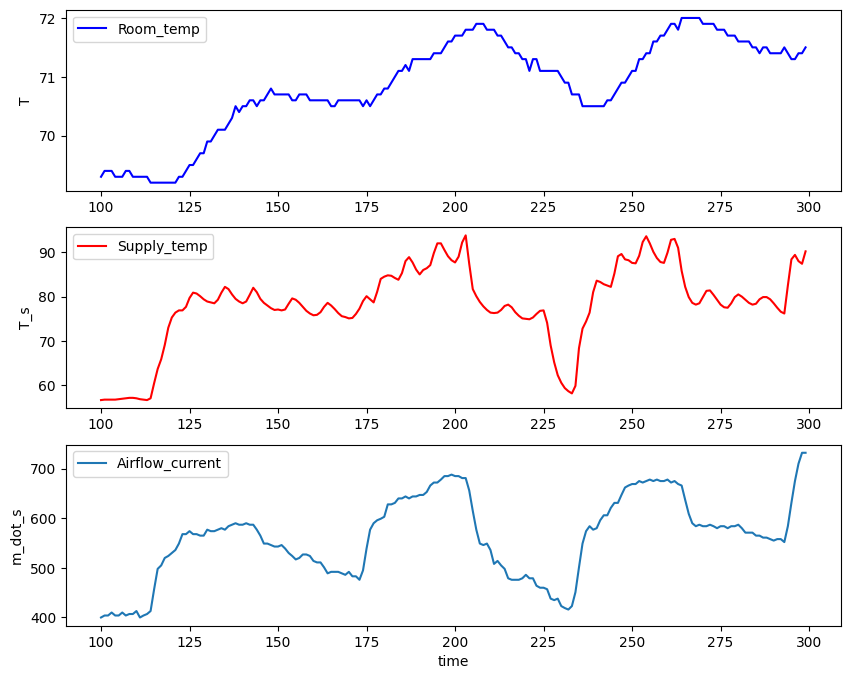

In [4]:
# plot the train data
start = 100
finish = 300
idx = np.arange(start, finish, 1)
fig = plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(idx, dataset['room_temp'][start:finish], 'b')
plt.ylabel('T')
plt.legend(["Room_temp"])

plt.subplot(3,1,2)
plt.plot(idx, dataset['supply_temp'][start:finish], 'r')
plt.ylabel('T_s')
plt.legend(["Supply_temp"])

plt.subplot(3,1,3)
plt.plot(idx, dataset['airflow_current'][start:finish])
plt.ylabel('m_dot_s')
plt.legend(["Airflow_current"])

plt.xlabel('time')

plt.show()

The data is represented in three subplots showing the room temperature, supply temperature, and airflow current. These plots confirm our intuition about the room’s temperature system since there is a direct relationship between the supply temperature and the airflow current with the room’s temperature. However, there is a delay between these parameters and the state of the system which is easily justifiable.

### Train/Test/Validation split (Global)

Here we devide our data into different groups of train, test, and validation and we will use this partitioning for all of our study. Since our data is temporal, we could not use the conventional random selection. So, we used the method suggestetd in [toardsdatascience.com](https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37).

In [5]:
train_nu = int(np.floor(0.7 * len(dataset)))
test_nu = int(np.floor(0.15 * len(dataset)))
val_nu = len(dataset) - train_nu - test_nu

# 2: Identifying the system's surrogate model


For the identification method for this project, we developed two methods. The first one is to use the differential equation model of the room temperature system and approximate its constant by fitting our model to the data. The second method is using deep learning techniques like recurrent neural network method for learning the data.

## 2.1: differential equation model

Our differential equation model is as follows,

$C\dot{T}  = K(T_a(t) - T(t))+\dot{m}_s(t) c_a (T_s(t)-T(t))+d(t)$

System output:
- $T(t)$: the room temperature at time $t$

Control parameters:
- $\dot{m}_s$: mass flow rate
- $T_s(t)$: temperature of the supply air

System parameters:
- $K$: the heat transfer coefficient
- $T_a$: the temperature outside the room at time $t$ (Constant)
- $c_a$: the specific heat capacity of air
- $d(t)$:the unknown disturbance into the room at time $t$ (Constant)
- $C$: the heat capacity of the room air,

For this system identification we used different optimization methods and here we give a brief summary of their performance. Later, we devlope the succesfull methods and see their results.


- gekko IPOPT : https://apmonitor.com/do/index.php/Main/TCLabA (Too Slow)
- solve_ivp + SciPy: Best optimization mrthod
- Julia: Similar result as SciPy



Let's import the necessary libraries.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import optimize
import scipy
import casadi as ca

Train/Test/Validation split

In [7]:
train_data = dataset[0:train_nu]
test_data = dataset[train_nu:train_nu + test_nu]
test_data = test_data.reset_index()
val_data= dataset[train_nu + test_nu: ]
val_data = val_data.reset_index()

### 2.1.1: solve_ivp + scipy

We define a function for room temperature model

In [8]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt

Then, we define a function for solving an initial value problem and plotting the difference between the ordinary differential equation model and actual data

In [9]:
def display_ode(p, model, dataset):


    Ts = np.array(dataset['supply_temp'])
    Ms = np.array(dataset['airflow_current'])
    T0 = dataset['room_temp'][0]
    t = np.arange(0, len(dataset), 1)
    T = np.zeros(len(dataset))
    T[0] = T0
    z0 = T0
    for i in range (1, len(dataset)):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]

    # plot results
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(t, T)
    plt.plot(t, dataset['room_temp'][t])
    plt.legend(["Model","Real Data"])
    plt.xlabel('time')
    plt.ylabel('T(t)')

    plt.subplot(1,2,2)
    plt.scatter(T/np.max(T), dataset['room_temp'][t]/np.max(dataset['room_temp'][t]))
    lolim = min(np.min(T/np.max(T)),
    np.min(dataset['room_temp'][t]/np.max(dataset['room_temp'][t])))
    uplim = 1
    plt.plot([lolim, uplim ], [lolim, uplim ], "k")
    plt.xlim(lolim , uplim )
    plt.ylim(lolim, uplim)

    plt.show()

Later, we create a function for the calculation of root mean squared error ($RMSE$) and $R^2$ score.

In [10]:
def RMSE_R2_ode(p, model, dataset):
    Ts = np.array(dataset['supply_temp'])
    Ms = np.array(dataset['airflow_current'])
    T0 = dataset['room_temp'][0]
    t = np.arange(0, len(test_data), 1)
    T = np.zeros(len(test_data))
    T[0] = T0
    z0 = T0
    for i in range (1, len(test_data)):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]
           
    actual = np.array(dataset['room_temp'][:len(test_data)])
    predicted = T
    rmse = np.sqrt(sum((actual-predicted)**2)/len(test_data))
    corr_matrix = np.corrcoef(actual, predicted)
    corr = corr_matrix[0,1]
    r_sq = corr**2

    return rmse, r_sq

Displaying the model performance on testing set before optimization

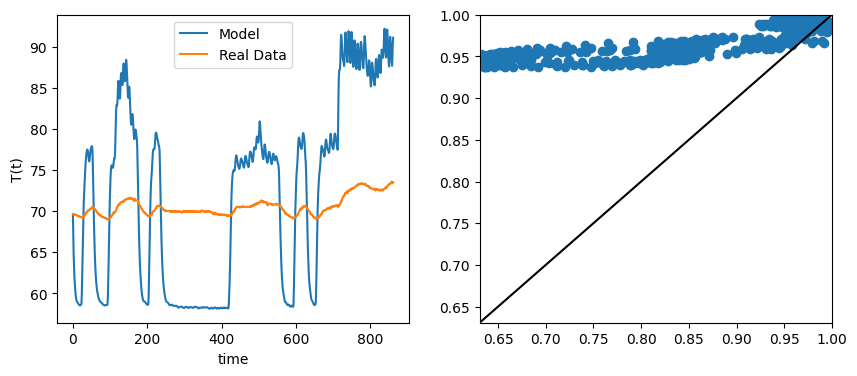

RMSE=10.715166594557873, Rsq=0.6567559364956972


In [11]:
p = [100, 70, 2, 10, 3000]
display_ode(p, model, test_data)
rmse, rsq = RMSE_R2_ode(p, model, test_data)
print("RMSE="+str(rmse)+", Rsq="+str(rsq))

Displaying the model performance on validation set before optimization

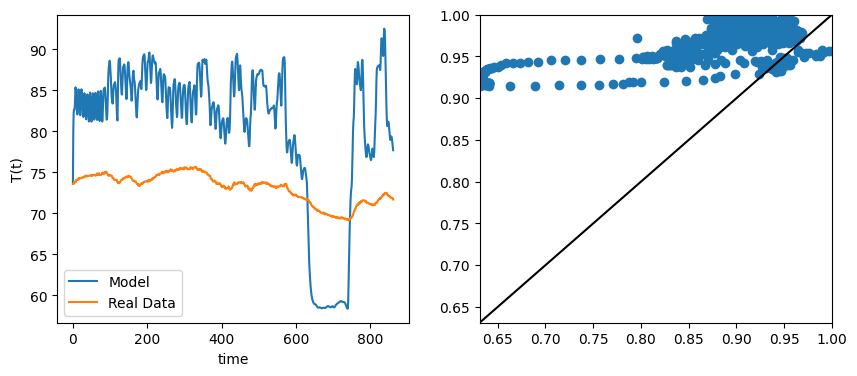

RMSE=10.658488942584196, Rsq=0.5762879456353054


In [12]:
p = [100, 70, 2, 10, 3000]
display_ode(p, model, val_data)
rmse, rsq = RMSE_R2_ode(p, model, val_data)
print("RMSE="+str(rmse)+", Rsq="+str(rsq))

Next, we define an objective function which calculate the root mean squared error between the model and actual data in the training set

In [13]:
def objective_func(p):
    Ts = np.array(train_data['supply_temp'])
    Ms = np.array(train_data['airflow_current'])
    T0 = train_data['room_temp'][0]
    t = np.arange(0, train_nu, 1)
    T = np.zeros(train_nu)
    T[0] = T0
    z0 = T0
    for i in range (1, train_nu):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]
           
    actual = np.array(train_data['room_temp'][:train_nu])
    predicted = T
    rmse = np.sqrt(sum((actual-predicted)**2)/train_nu)
    return rmse

Finally, we use SLSQP optimization for finding the constants in our differential equation. This method requires the lower- and upper-bound for optimization variables. So, we used the feasible range of each of the variables for their bounds. The $d(t)$ was defined as air disturbance in the systems and since we are assigning a constant value to it is not intuitive to give it a wide range.

In [19]:
initial_condition = ([100, 70, 2, 10, 3000])
bnds = ((0, 300),
        (30, 100),
        (0.001, 10),
        (-100, 100),
        (1000, 10000))
Nfeval = 0
def mycallback(x):
  global Nfeval
  cost = objective_func(x)
  Nfeval += 1
  print ('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}   {5: 3.6f}  {6: 3.6f}'.format(Nfeval, x[0], x[1], x[2], x[3], x[4], cost))

print('{0:4s}        {1:9s}     {2:9s}   {3:9s}   {4:9s}     {5:9s}   {6:9s}'.format('Iter', 'K', 'Ta', 'ca', ' d', 'C', 'Cost')) 
res = scipy.optimize.minimize(objective_func, initial_condition, method='SLSQP', bounds=bnds, tol=1e-6, callback=mycallback)

Iter        K             Ta          ca           d            C           Cost     
   1    100.010027    69.984692    1.401746    9.999846    2000.000097   11.410973


d:\Control\01-Learning and controlling a room's temperature\MPC\.venvMPC\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


   2    100.036398    69.939567    0.001000    9.999394    2000.000355   2.130595
   3    100.023415    69.971344    1.382942    9.999712    2000.000228   11.389061
   4    100.046744    70.109330    0.030632    10.001091    2000.000491   0.814699
   5    100.051287    70.820641    0.001000    10.008201    2000.000842   1.622634
   6    100.046549    70.540232    0.021966    10.005398    2000.000716   0.655452
   7    100.044246    70.591241    0.022226    10.005907    2000.000847   0.653690
   8    100.042486    70.590230    0.022088    10.005897    2000.000935   0.653625
   9    100.040509    70.588552    0.022108    10.005880    2000.001033   0.653620
  10    100.032679    70.586577    0.022135    10.005860    2000.001424   0.653607
  11    99.997109    70.581997    0.022193    10.005813    2000.003198   0.653558
  12    99.902958    70.575288    0.022268    10.005740    2000.007898   0.653445
  13    99.626557    70.563499    0.022376    10.005608    2000.021697   0.653136
  14    

Save the optimization result

In [20]:
pd.DataFrame(res.x).to_csv("SLSQP_opt_param.csv", header=None, index=None)

Display the performance of the optimized model on the test set

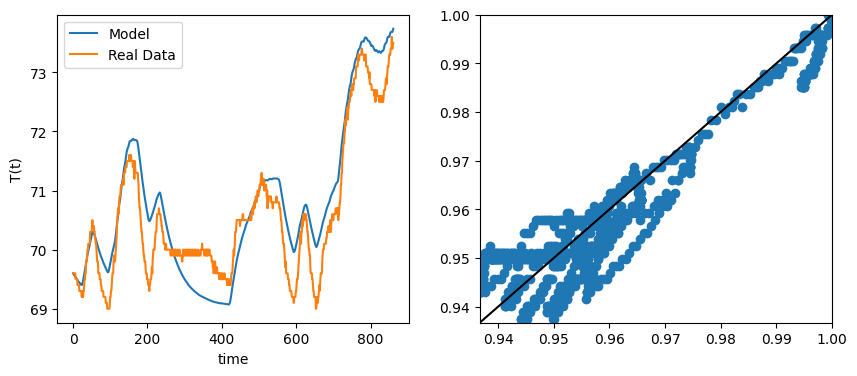

RMSE=0.5198310021920144, Rsq=0.8680754760059595


In [29]:
p = np.array(pd.read_csv('SLSQP_opt_param.csv', header=None)[0])
display_ode(p, model, test_data)
rmse_test, rsq_test = RMSE_R2_ode(p, model, test_data)
print("RMSE="+str(rmse_test)+", Rsq="+str(rsq_test))

Display the performance of the optimized model on the validation set

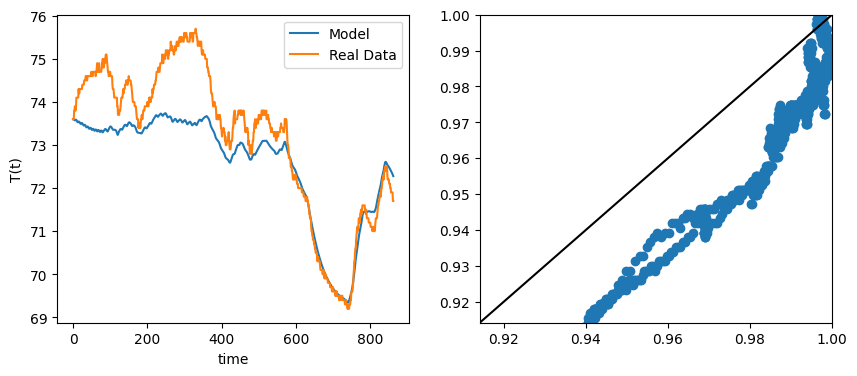

RMSE=0.8917440131112756, Rsq=0.9223736968232853


In [30]:
p = np.array(pd.read_csv('SLSQP_opt_param.csv', header=None)[0])
display_ode(p, model, val_data)
rmse_val, rsq_val = RMSE_R2_ode(p, model, val_data)
print("RMSE="+str(rmse_val)+", Rsq="+str(rsq_val))

Let's save the result for future use

In [23]:
model_compare = pd.DataFrame(np.array([rmse_test, rsq_test, rmse_val, rsq_val]).reshape(1, -1),
                columns = ["rmse_test", "rsq_test", "rmse_val", "rsq_val"],
                index=['ode'])
                
model_compare.to_csv("Model_comparison.csv")

Finally, we compare all the developed method of optimization

In [24]:
# Julia results
p = np.array([ 188.99, 63.23, 0.051, 1377.81, 9755.25])
j_rmse, j_rsq = RMSE_R2_ode(p, model, test_data)

p = np.array([62.62, 70.30, 0.017, 10.00, 3001.24])
P_rmse, P_rsq = RMSE_R2_ode(p, model, test_data)

print("Julia result :" + "RMSE=" + str(j_rmse) + "," + " R_sq=" + str(j_rsq))
print("Python result :" + "RMSE=" + str(P_rmse) + "," + " R_sq=" + str(P_rsq))

Julia result :RMSE=0.5289130373872404, R_sq=0.861966830424802
Python result :RMSE=0.5176612955019463, R_sq=0.8679569522807724


## 2.2: Learn  a Neural Network Model

Neural networks are one of the most prominent techniques in identifying the relationship between data. There are several structures for neural networks among which the recurrent neural network is the most suitable for temporal data. The long short-term memory network is a special kind of neural network that is developed for handling large sequences of data since it does not suffer from vanishing gradients. In this project, we developed the LSTM neural network in both TensorFlow and PyTorch to investigate their compatibility with our optimizer in the MPC section.



### 2.2.1: LSTM via tensorflow
In the process of developing this neural network we used several useful resources as follows:
- [Recurrent Neural Networks (RNN) by sentdex](https://www.youtube.com/watch?v=BSpXCRTOLJA&list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN&index=7)
- [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
- [How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

First, we import the necessary libraries for developing a neural network

In [32]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.optimizers import Adam

Then, we load our data to the environment

In [33]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv', header=0, index_col=0)
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

                       room_temp  supply_temp  airflow_current
time                                                          
2021-04-26T09:37:00.0       72.3         59.3              416
2021-04-26T09:38:00.0       72.2         58.8              413
2021-04-26T09:39:00.0       72.2         58.5              419
2021-04-26T09:40:00.0       72.1         58.2              410
2021-04-26T09:41:00.0       71.9         58.1              404


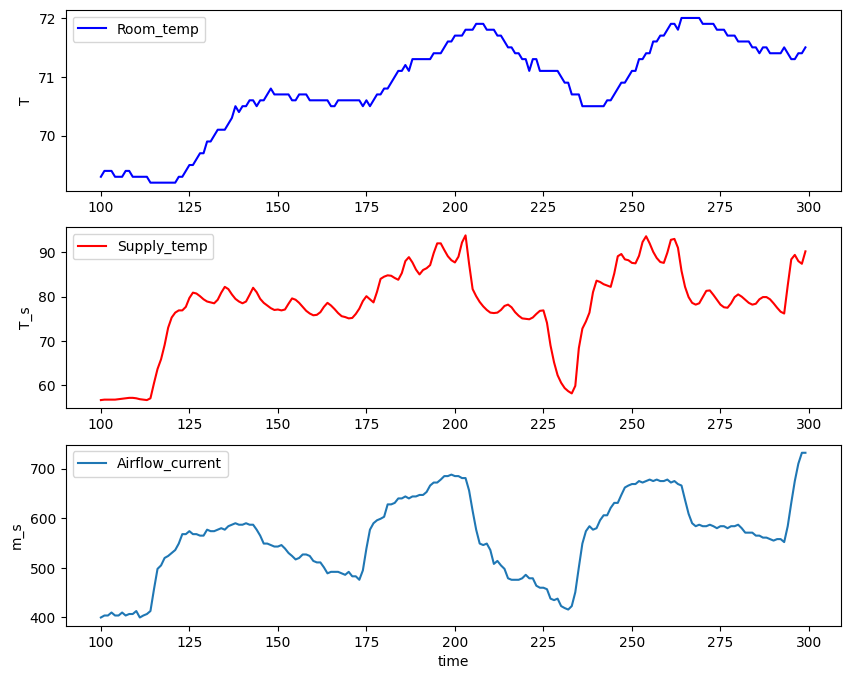

In [34]:
# plot the train data
start = 100
finish = 300
idx = np.arange(start, finish, 1)
fig = plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(idx, dataset['room_temp'][start:finish], 'b')
plt.ylabel('T')
plt.legend(["Room_temp"])

plt.subplot(3,1,2)
plt.plot(idx, dataset['supply_temp'][start:finish], 'r')
plt.ylabel('T_s')
plt.legend(["Supply_temp"])

plt.subplot(3,1,3)
plt.plot(idx, dataset['airflow_current'][start:finish])
plt.ylabel('m_s')
plt.legend(["Airflow_current"])

plt.xlabel('time')

plt.show()

Here, we define a function that changes the shape of our data and makes it compatible for supervised learning

In [35]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

We normalize the data and use the function to change our data

In [36]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
print('maximum value :' + str(scaler.data_max_))
print('minimum value :' + str(scaler.data_min_))
scaled = scaler.transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.head())

maximum value :[  75.7   97.  1003. ]
minimum value :[ 68.5  56.2 394. ]
   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.527779   0.075980   0.036125  0.513889
2   0.513889   0.063725   0.031199  0.513889
3   0.513889   0.056373   0.041051  0.500000
4   0.500000   0.049020   0.026273  0.472223
5   0.472223   0.046569   0.016420  0.458334


As you can see the data is changed and to $T(k)$, $T_s(k)$, $M_s(k)$, $T(k+1)$  so it can be used to learn the following function:
 
 $T(k+1) = F(T(k), T_s(k), M_s(k))$


After that, we just reshape our data to the prescribed shapes of the LSTM network.

In [37]:
...
# split into train and test sets
values = reframed.values
train = values[0:train_nu]
test = values[train_nu:train_nu + test_nu]
validation= values[train_nu + test_nu: ]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
val_X, val_y = validation[:, :-1], validation[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

(4022, 1, 3) (4022,) (862, 1, 3) (862,) (862, 1, 3) (862,)


Here, we define our neural network model architecture and hyperparameters. Then, we train our model

In [38]:
...
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
opt = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt)

Epoch 1/100
32/32 - 5s - loss: 0.1581 - val_loss: 0.0264 - 5s/epoch - 153ms/step
Epoch 2/100
32/32 - 0s - loss: 0.0499 - val_loss: 0.0076 - 166ms/epoch - 5ms/step
Epoch 3/100
32/32 - 0s - loss: 0.0164 - val_loss: 0.0140 - 141ms/epoch - 4ms/step
Epoch 4/100
32/32 - 0s - loss: 0.0127 - val_loss: 0.0126 - 146ms/epoch - 5ms/step
Epoch 5/100
32/32 - 0s - loss: 0.0120 - val_loss: 0.0112 - 145ms/epoch - 5ms/step
Epoch 6/100
32/32 - 0s - loss: 0.0113 - val_loss: 0.0103 - 147ms/epoch - 5ms/step
Epoch 7/100
32/32 - 0s - loss: 0.0105 - val_loss: 0.0093 - 153ms/epoch - 5ms/step
Epoch 8/100
32/32 - 0s - loss: 0.0098 - val_loss: 0.0084 - 148ms/epoch - 5ms/step
Epoch 9/100
32/32 - 0s - loss: 0.0091 - val_loss: 0.0076 - 154ms/epoch - 5ms/step
Epoch 10/100
32/32 - 0s - loss: 0.0084 - val_loss: 0.0068 - 156ms/epoch - 5ms/step
Epoch 11/100
32/32 - 0s - loss: 0.0077 - val_loss: 0.0061 - 153ms/epoch - 5ms/step
Epoch 12/100
32/32 - 0s - loss: 0.0070 - val_loss: 0.0054 - 156ms/epoch - 5ms/step
Epoch 13/100
3

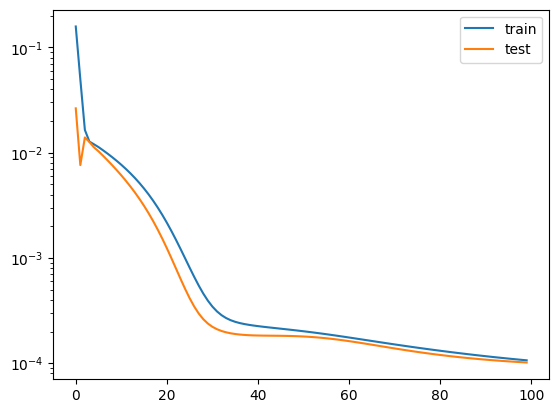

In [39]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yscale('log')

plt.show()

Let's save our trained model

In [33]:
model.save('/content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp\assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp\assets


Here, we define the RMSE_R2 and display functions.

In [34]:
def RMSE_R2(actual, predicted):
     
    rmse = np.sqrt(sum((actual-predicted)**2)/len(actual))
    corr_matrix = np.corrcoef(actual, predicted)
    corr = corr_matrix[0,1]
    r_sq = corr**2

    return rmse, r_sq


In [35]:
def display(actual, predicted):

    t = np.arange(0, len(actual), 1)
    # plot results
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(t, predicted)
    plt.plot(t, actual)
    plt.legend(["Model","Real Data"])
    plt.xlabel('time')
    plt.ylabel('T(t)')

    plt.subplot(1,2,2)
    plt.scatter(predicted/np.max(predicted), actual/np.max(actual))
    lolim = min(np.min(predicted/np.max(predicted)),
    np.min(actual/np.max(actual)))
    uplim = 1
    plt.plot([lolim, uplim ], [lolim, uplim ], "k")
    plt.xlim(lolim , uplim )
    plt.ylim(lolim, uplim)

    plt.show()

Make prediction for testing and validation set.

In [36]:
# make a prediction
yhat_test = model.predict(test_X)
inv_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat_test = np.concatenate((yhat_test, inv_test_X[:, 1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]
# invert scaling for actual
inv_y_test = test_y.reshape((len(test_y), 1))
inv_y_test = np.concatenate((inv_y_test, inv_test_X[:, 1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]

27/27 [==============================] - 1s 2ms/step


In [37]:
# make a prediction
yhat_val = model.predict(val_X)
inv_val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
# invert scaling for forecast
inv_yhat_val = np.concatenate((yhat_val, inv_val_X[:, 1:]), axis=1)
inv_yhat_val = scaler.inverse_transform(inv_yhat_val)
inv_yhat_val = inv_yhat_val[:,0]
# invert scaling for actual
inv_y_val = val_y.reshape((len(val_y), 1))
inv_y_val = np.concatenate((inv_y_val, inv_val_X[:, 1:]), axis=1)
inv_y_val = scaler.inverse_transform(inv_y_val)
inv_y_val = inv_y_val[:,0]

27/27 [==============================] - 0s 1ms/step


test_set analysis

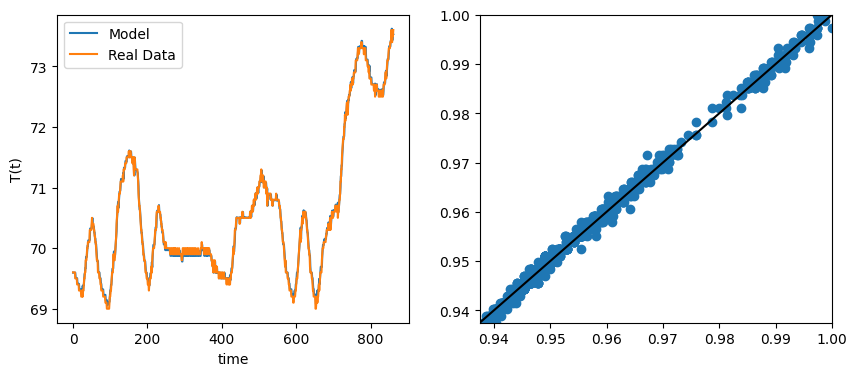

RMSE=0.07112568328084867, Rsq=0.9962537972593642


In [38]:
display(inv_y_test, inv_yhat_test)
rmse_test, rsq_test = RMSE_R2(inv_y_test, inv_yhat_test)
print("RMSE="+str(rmse_test)+", Rsq="+str(rsq_test))

Validation set analysis

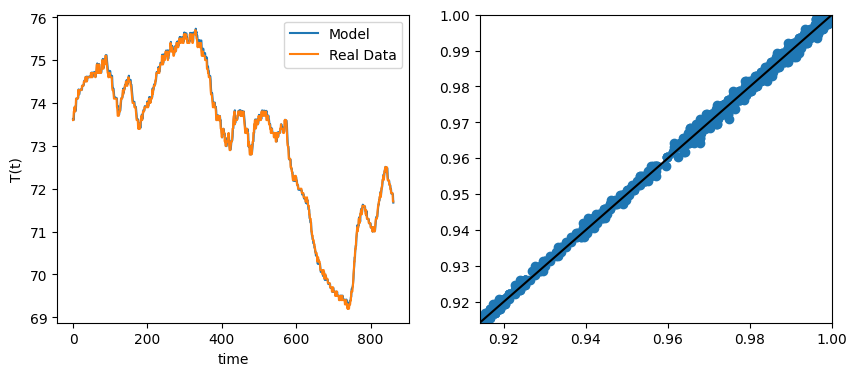

RMSE=0.08187584237324674, Rsq=0.9979761620991489


In [39]:
display(inv_y_val, inv_yhat_val)
rmse_val, rsq_val = RMSE_R2(inv_y_val, inv_yhat_val)
print("RMSE="+str(rmse_val)+", Rsq="+str(rsq_val))

Let's save the results

In [40]:
model_compare = pd.read_csv('Model_comparison.csv', index_col=0)
new_row = pd.DataFrame(np.array([rmse_test, rsq_test, rmse_val, rsq_val]).reshape(1, -1),
                columns = ["rmse_test", "rsq_test", "rmse_val", "rsq_val"], index=['keras'],
                )
if 'keras' in model_compare.index:
    print('start from ODE result')
    
model_compare = model_compare.append(new_row)
model_compare.to_csv("Model_comparison.csv")

C:\Users\FarzadLT1\AppData\Local\Temp\ipykernel_10852\627433114.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_compare = model_compare.append(new_row)


### Section 2.2.2: Pytorch

Neural network development with pytorch requires similar steps like tensorflow. 

In the process of developing this neural network we followed the instructions in the [cnvrg.io](https://cnvrg.io/pytorch-lstm/) 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error

In [41]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv', header=0, index_col=0)
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

                       room_temp  supply_temp  airflow_current
time                                                          
2021-04-26T09:37:00.0       72.3         59.3              416
2021-04-26T09:38:00.0       72.2         58.8              413
2021-04-26T09:39:00.0       72.2         58.5              419
2021-04-26T09:40:00.0       72.1         58.2              410
2021-04-26T09:41:00.0       71.9         58.1              404


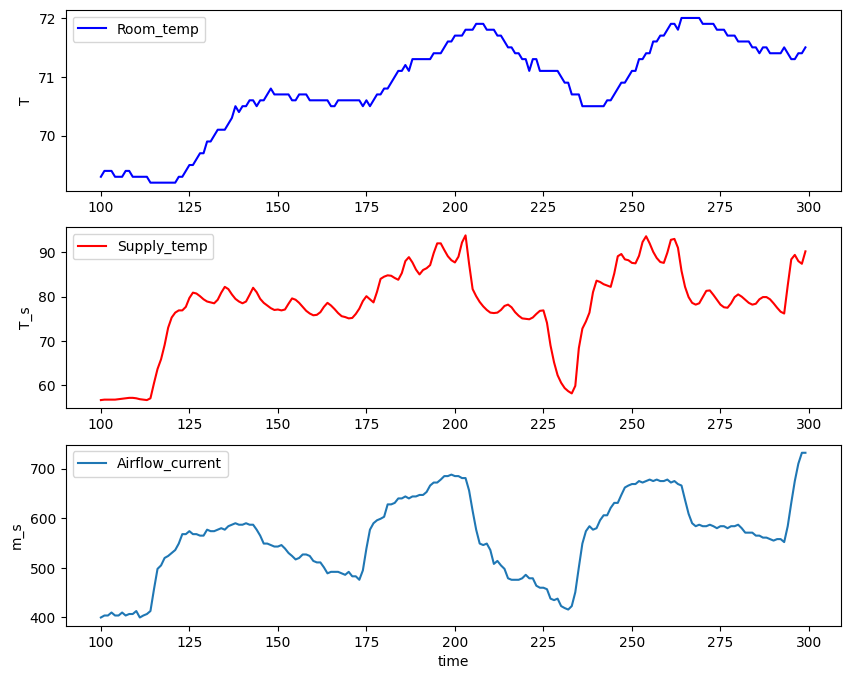

In [42]:
# plot the train data
start = 100
finish = 300
idx = np.arange(start, finish, 1)
fig = plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(idx, dataset['room_temp'][start:finish], 'b')
plt.ylabel('T')
plt.legend(["Room_temp"])

plt.subplot(3,1,2)
plt.plot(idx, dataset['supply_temp'][start:finish], 'r')
plt.ylabel('T_s')
plt.legend(["Supply_temp"])

plt.subplot(3,1,3)
plt.plot(idx, dataset['airflow_current'][start:finish])
plt.ylabel('m_s')
plt.legend(["Airflow_current"])

plt.xlabel('time')

plt.show()

In [43]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [44]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
print('maximum value :' + str(scaler.data_max_))
print('minimum value :' + str(scaler.data_min_))
scaled = scaler.transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.head())

maximum value :[  75.7   97.  1003. ]
minimum value :[ 68.5  56.2 394. ]
   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.527779   0.075980   0.036125  0.513889
2   0.513889   0.063725   0.031199  0.513889
3   0.513889   0.056373   0.041051  0.500000
4   0.500000   0.049020   0.026273  0.472223
5   0.472223   0.046569   0.016420  0.458334


In [45]:
...
# split into train and test sets
values = reframed.values
train = values[0:train_nu]
test = values[train_nu:train_nu + test_nu]
validation= values[train_nu + test_nu: ]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_val, y_val = validation[:, :-1], validation[:, -1]

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [46]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 
print("Validation Shape", X_val.shape, y_val.shape) 

Training Shape (4022, 3) (4022, 1)
Testing Shape (862, 3) (862, 1)
Validation Shape (862, 3) (862, 1)


In [47]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [48]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [49]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4022, 1, 3]) torch.Size([4022, 1])
Testing Shape torch.Size([862, 1, 3]) torch.Size([862, 1])


In [50]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, num_classes) #fully connected 1
        # self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        # out = self.relu(out) #relu
        # out = self.fc(out) #Final Output
        return out

In [51]:
num_epochs = 100 #100 epochs
learning_rate = 0.001 #0.01 lr

input_size = 3 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
BATCH_SIZE = 128 # Number of batch size

In [52]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [53]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [54]:
dataset_train = torch.utils.data.TensorDataset(X_train_tensors_final, y_train_tensors)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False)

In [55]:
loss = np.zeros(num_epochs)
valloss = np.zeros(num_epochs)
for epoch in range(num_epochs):
  for id_batch, (x_batch, y_batch) in enumerate(dataloader_train):
    optimizer.zero_grad() 
    outputs = lstm1.forward(x_batch) #forward pass
    # obtain the loss function
    loss_train = criterion(outputs, y_batch)
    loss_train.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backprop

  outputs = lstm1.forward(X_test_tensors_final)
  loss_test = criterion(outputs, y_test_tensors)
  loss[epoch] =  loss_train.item()
  valloss[epoch] =  loss_test.item()

  if epoch % 5 == 0:
    print("Epoch: %d, loss: %1.5f, valloss: %1.5f" % (epoch, loss_train.item(), loss_test.item())) 

Epoch: 0, loss: 0.01642, valloss: 0.04281
Epoch: 5, loss: 0.00824, valloss: 0.01847
Epoch: 10, loss: 0.00184, valloss: 0.00745
Epoch: 15, loss: 0.00122, valloss: 0.00271
Epoch: 20, loss: 0.00073, valloss: 0.00073
Epoch: 25, loss: 0.00031, valloss: 0.00021
Epoch: 30, loss: 0.00013, valloss: 0.00016
Epoch: 35, loss: 0.00011, valloss: 0.00017
Epoch: 40, loss: 0.00010, valloss: 0.00015
Epoch: 45, loss: 0.00009, valloss: 0.00013
Epoch: 50, loss: 0.00008, valloss: 0.00011
Epoch: 55, loss: 0.00008, valloss: 0.00011
Epoch: 60, loss: 0.00008, valloss: 0.00010
Epoch: 65, loss: 0.00008, valloss: 0.00010
Epoch: 70, loss: 0.00008, valloss: 0.00010
Epoch: 75, loss: 0.00008, valloss: 0.00010
Epoch: 80, loss: 0.00008, valloss: 0.00010
Epoch: 85, loss: 0.00008, valloss: 0.00010
Epoch: 90, loss: 0.00008, valloss: 0.00010
Epoch: 95, loss: 0.00008, valloss: 0.00010


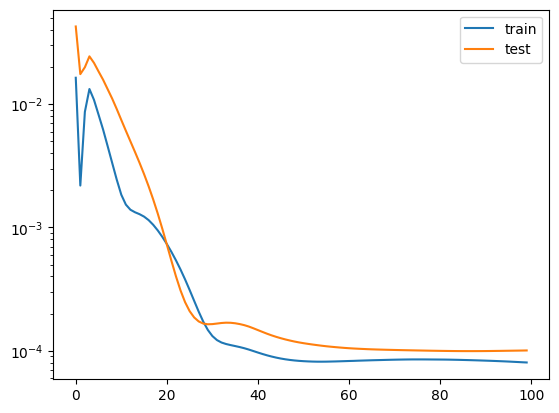

In [56]:
# plot history
plt.plot(loss, label='train')
plt.plot(valloss, label='test')
plt.legend()
plt.yscale('log')

plt.show()

In [57]:
def display(actual, predicted):

    t = np.arange(0, len(actual), 1)
    # plot results
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(t, predicted)
    plt.plot(t, actual)
    plt.legend(["Model","Real Data"])
    plt.xlabel('time')
    plt.ylabel('Temperature')

    plt.subplot(1,2,2)
    plt.scatter(predicted/np.max(predicted), actual/np.max(actual))
    lolim = min(np.min(predicted/np.max(predicted)),
    np.min(actual/np.max(actual)))
    uplim = 1
    plt.plot([lolim, uplim ], [lolim, uplim ], "k")
    plt.xlim(lolim , uplim )
    plt.ylim(lolim, uplim)
    plt.xlabel('Predicted Data')
    plt.ylabel('Actual Data')
    plt.show()

In [58]:
def RMSE_R2(actual, predicted):
     
    rmse = np.sqrt(sum((actual-predicted)**2)/len(actual))
    corr_matrix = np.corrcoef(actual, predicted)
    corr = corr_matrix[0,1]
    r_sq = corr**2

    return rmse, r_sq

In [59]:
X_test_tensor = Variable(torch.Tensor(X_test)) #converting to Tensors
#reshaping the dataset
X_test_tensor = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], 1, X_test_tensor.shape[1]))
test_predict = lstm1(X_test_tensor)#forward pass
test_predict = test_predict.data.numpy() #numpy conversion

inv_test_predict = np.concatenate((test_predict, X_test[:, 1:]), axis=1)
inv_test_predict = scaler.inverse_transform(inv_test_predict)
inv_test_predict = inv_test_predict[:,0]

inv_test = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_test = scaler.inverse_transform(inv_test)
inv_test = inv_test[:,0]

In [60]:
X_val_tensor = Variable(torch.Tensor(X_val)) #converting to Tensors
#reshaping the dataset
X_val_tensor = torch.reshape(X_val_tensor, (X_val_tensor.shape[0], 1, X_val_tensor.shape[1]))
val_predict = lstm1(X_val_tensor)#forward pass
val_predict = val_predict.data.numpy() #numpy conversion

inv_val_predict = np.concatenate((val_predict, X_val[:, 1:]), axis=1)
inv_val_predict = scaler.inverse_transform(inv_val_predict)
inv_val_predict = inv_val_predict[:,0]

inv_val = np.concatenate((y_val, X_val[:, 1:]), axis=1)
inv_val = scaler.inverse_transform(inv_val)
inv_val = inv_val[:,0]

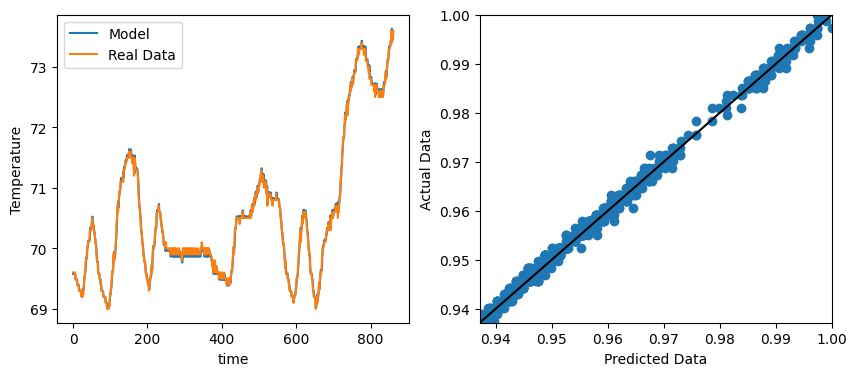

RMSE=0.07210848309915503, Rsq=0.9962475425824794


In [61]:
display(inv_test, inv_test_predict)
rmse_test, rsq_test = RMSE_R2(inv_test, inv_test_predict)
print("RMSE="+str(rmse_test)+", Rsq="+str(rsq_test))

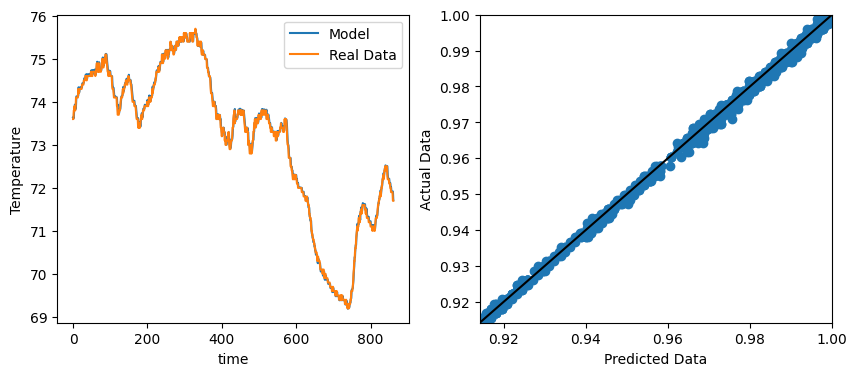

RMSE=0.07896574737025477, Rsq=0.9980923730308138


In [62]:
display(inv_val, inv_val_predict)
rmse_val, rsq_val = RMSE_R2(inv_val, inv_val_predict)
print("RMSE="+str(rmse_val)+", Rsq="+str(rsq_val))

In [67]:
model_compare = pd.read_csv('Model_comparison.csv', index_col=0)
new_row = pd.DataFrame(np.array([rmse_test, rsq_test, rmse_val, rsq_val]).reshape(1, -1),
                columns = ["rmse_test", "rsq_test", "rmse_val", "rsq_val"], index=['pytorch'],
                )
if 'pytorch' in model_compare.index:
    print('start from ODE result')
 
model_compare = model_compare.append(new_row)
model_compare.to_csv("Model_comparison.csv")

start from ODE result


C:\Users\FarzadLT1\AppData\Local\Temp\ipykernel_7088\3698103975.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_compare = model_compare.append(new_row)


In [68]:
torch.save(lstm1.state_dict(), "Pytorch_LSTM.pth")

## 2.3: Models comparison

We compare the RMSE and R2 for of all our models in both testing and validation set

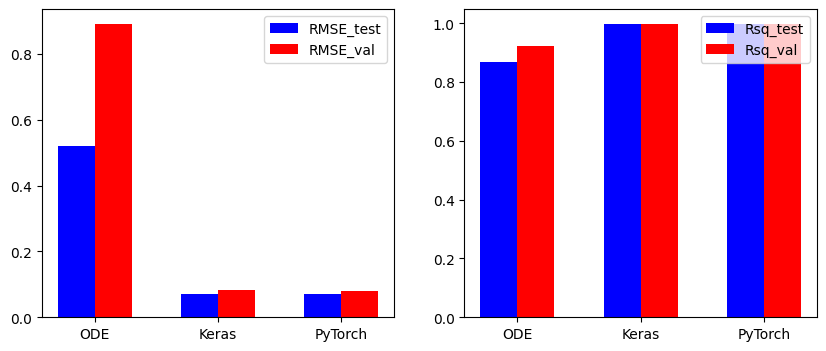

In [243]:
model_compare = pd.read_csv('Model_comparison.csv', index_col=0)
ind = np.arange(3)
# x = ['ODE', 'Keras', 'Pytorch']
bar_width = 0.3 
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(ind, model_compare['rmse_test'].to_numpy(),
         color='b', width=bar_width,
         label='RMSE_test')

plt.bar(ind + bar_width, model_compare['rmse_val'].to_numpy(),
         color='r', width=bar_width,
         label='RMSE_val')
plt.legend(loc='best')
plt.xticks(ind + bar_width / 2, ('ODE', 'Keras', 'PyTorch'))

plt.subplot(1, 2, 2)
plt.bar(ind, model_compare['rsq_test'].to_numpy(),
         color='b', width=bar_width,
         label='Rsq_test')

plt.bar(ind + bar_width, model_compare['rsq_val'].to_numpy(),
         color='r', width=bar_width,
         label='Rsq_val')
plt.legend(loc='best')
plt.xticks(ind + bar_width / 2, ('ODE', 'Keras', 'PyTorch'))

plt.show()



# 3: MPC
After identifying the model for our system in the previous section. We are ready to implement the MPC. The objective function and the constraints for our MPC are as follows:

$Objective\:function = \sum_{n=0}^{N}((y_{pre}(n) - y_{ref})^2 + c \times (a(T_s(n) - 55) + b(\dot{m}_s(n)-400)^2))$

$ Subject\:to: 55<T_s<90,\: 400<\dot{m}_s<1000
$  

$ Subject\:to:|\Delta{T_s}|<8,\: |\Delta{\dot{m}_s}|<65$

Where $y_{pre}$ is the predicted state of our model based on the optimzied control inputs in the prediction horizon. $y_{ref}$ is the reference state for control, and $N$ is the horizon length. So, the First part of our network calculate the difference between our desired state with the predicted state. The second part of is called activatin cost and it aims to reduce the energy spenditure of the controller. 

In the process of developing this section we used numerous resources. Here, we list the most important ones.
- Model Predictive Control by Steve Brunton [ [link](https://www.youtube.com/watch?v=YwodGM2eoy4) ]
- A series of lectures by Mohamed W. Mehrez [ [link](https://www.youtube.com/watch?v=RrnkPrcpyEA) ]
- John Hedengren site [ [link](https://apmonitor.com/do/index.php/Main/TCLabG) ]
- A series of lectures by MathWorks [ [link](https://www.youtube.com/playlist?list=PLn8PRpmsu08ozoeoXgxPSBKLyd4YEHww8) ]
- CasADi documentation [ [link](https://web.casadi.org/docs/) ]
- A great video by APMonitor [ [link](https://www.youtube.com/watch?v=DFqOf5wbQtc) ]

- CasADi blog post [ [link](https://web.casadi.org/blog/tensorflow/) ]
- Introduction of CasADi [ [link](https://www.youtube.com/watch?v=JC6PNjndQ_c&t=61s
) ]

Papers :
- Real-time Neural-MPC: Deep Learning Model Predictive Control for Quadrotors and Agile Robotic Platforms[ [link](https://arxiv.org/abs/2203.07747) ]
- Recurrent Neural Network-Based Model Predictive Control for Continuous Pharmaceutical Manufacturing [ [link](https://www.mdpi.com/2227-7390/6/11/242/htm) ]

## 3.1: Casadi + ODE

In [111]:
# import libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from casadi import *
from casadi.tools import *

#######################################
##########  Parameters  ###############
#######################################

N = 3 # Horizon length
runtime = 50
dt = 1;          # Time step
x0 = 70.0        # Initial temperature
xs = 72.5        # Reference Temperature

# Equation patameters derived from parameters estimation
k_ep = 62.62
Ta_ep = 70.30
ca_ep = 0.017
d_ep = 10.0
C_ep = 3001.24

# Constraints parameters
max_delta_Ts = 8.0
min_delta_Ts = -8.0

max_delta_Ms = 65.0
min_delta_Ms = -65.0

max_Ts = 90.0
min_Ts = 55.0

max_Ms = 1000.0
min_Ms = 400.0

min_Ts_global = 55.0
min_Ms_global = 400.0


# Optimization parameters
obj = 0
a = 1
b = 1e-2
c = 1e-5


#######################################
#######  CasADi optimization   ########
#######################################

#states
states = struct_symSX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symSX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


rhs = struct_SX(states)
rhs["T"] = (k_ep * (Ta_ep - T) + Ms * ca_ep * (Ts - T) + d_ep) / C_ep

f = Function('f', [states, controls],[rhs])

# Build an integrator for this system: Runge Kutta 4 integrator
k1 = f(states,controls)
k2 = f(states+dt/2.0*k1,controls)
k3 = f(states+dt/2.0*k2,controls)
k4 = f(states+dt*k3,controls)
states_1 = states+dt/6.0*(k1+2*k2+2*k3+k4)
phi = Function('phi', [states, controls],[states_1])


# Create tructure for the entire horizon
variables = struct_symSX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symSX([entry("x0", shape=(6, 1))])

# objective function
obj += (parameters["x0", 0] - parameters["x0", 1])**2 + c*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = phi(parameters["x0", 0], variables["U", 0])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + c*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = phi(parameters["x0", 0], variables["U", k])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)


# define lower and upper bound for constraints
args = {}
upperb = []
lowerb = []
for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)

args['lbg'] = lowerb
args['ubg'] = upperb

#######################################
##########  MPC simulation  ###########
#######################################

# define empty arrays o store simulation data
t = np.arange(0, runtime, dt)
xxs = np.full((runtime,1), xs)
xx = []
xx.append(x0)
cost = []
TTs = []
TTs.append(min_Ts)
MMs = []
MMs.append(min_Ms)


# The initial guess for optimization
u0 = []
for i in range(N):
  u0 += [55]
  u0 += [400]


# simulate
args['x0'] = u0

for i in range(1,runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])

  st_next = phi(args['p'][0], sol['x'][0:2])

  # shift to the next time 
  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]

  # Use the result of MPC optimization as next
  #  stage optimization initial guess
  args['x0'] = vertcat(sol['x'][2:],sol['x'][:2])
  
  #store the simulation data
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])

cost.insert(0, cost[0])

      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  54.00us (  2.08us)        26
       nlp_g  |   1.00ms ( 38.46us)  70.00us (  2.69us)        26
    nlp_grad  |        0 (       0)   8.00us (  8.00us)         1
  nlp_grad_f  |        0 (       0)  68.00us (  2.72us)        25
   nlp_jac_g  |        0 (       0)  33.00us (  1.32us)        25
       total  |  62.00ms ( 62.00ms)  62.75ms ( 62.75ms)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  30.00us (  1.87us)        16
       nlp_g  |        0 (       0)  32.00us (  2.00us)        16
    nlp_grad  |        0 (       0)   5.00us (  5.00us)         1
  nlp_grad_f  |        0 (       0)  40.00us (  2.35us)        17
   nlp_jac_g  |        0 (       0)  18.00us (  1.06us)        17
       total  |  44.00ms ( 44.00ms)  43.25ms ( 43.25ms)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

Display the the optimization result

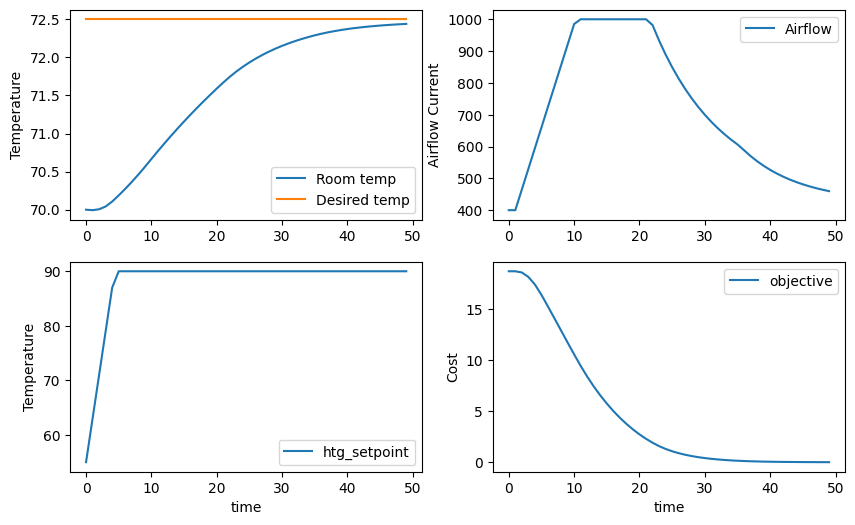

In [112]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx)
plt.plot(t, xxs)
plt.legend(['Room temp', 'Desired temp'])
plt.ylabel('Temperature')

plt.subplot(2, 2, 2)
plt.plot(t, MMs)
plt.legend(['Airflow'])
plt.ylabel('Airflow Current')

plt.subplot(2, 2, 3)
plt.plot(t, TTs)
plt.legend(['htg_setpoint'])
plt.xlabel('time')
plt.ylabel('Temperature')

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])
plt.xlabel('time')
plt.ylabel('Cost')
plt.savefig("myImagePDF1.pdf", format="pdf", bbox_inches="tight") # save fig for post processing
plt.show()


## 3.2 CasADi + LSTM (Keras)

Here, we try to use the pre-trained neural network as a function for predicting the state of the plant. The overall code is pretty similar to the previous section; however, the loading of the neural network model, normalizing the data for the neural network, and callback function for integrating the neural network to CasADi has been added to this code.

First, we import our libraries

In [113]:
from casadi import *
from casadi.tools import *
from scipy import linalg, matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



In [114]:
LSTM_model = tf.keras.models.load_model("LSTM_room_temp")

Then, we define our callback function and use the neural network here in this function to predict the state

In [115]:
# Callback function for evaluating LSTM

class MyCallback(Callback):
  def __init__(self, name, opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 3
  def get_n_out(self): return 1

  # Initialize the object
  def init(self):
     print('initializing object')

  # Evaluate numerically
  def eval(self, arg):
    input = np.array([arg[0], arg[1], arg[2]]).astype('float32').reshape(1,-1)
    input_reframed = input.reshape((input.shape[0], 1, input.shape[1]))
    f = LSTM_model(input_reframed)
    return [f.numpy()[0, 0]]
lstm = MyCallback('lstm', {"enable_fd":True})

initializing object


Here, we define our normalizng function for normalizing the data for neural network. We, normalize all the MPC simulation since the neural network input sould be normalized and we dont want to add normlization process before the network itself since it makes the optimization process slower.

In [116]:
def normal(x, min, max):
    norm = (x - min)/(max - min)
    return norm

def revnormal(x, min, max):
    norm = (x * (max - min)) + min
    return norm

def normaldelta(x, min, max):
    norm = (x)/(max - min)
    return norm

Note: If you get the error for scaler is not define you have to re-run the neural network part to find the best normalization parameters that is saved in scalar

In [117]:
#######################################
##########  Parameters  ###############
#######################################

N = 3 # Horizon length
runtime = 50
dt = 1;          # Time step
x0 = 70.0        # Initial temperature
xs = 72.5        # Reference Temperature

# Constraints parameters
max_delta_Ts = 8.0
min_delta_Ts = -8.0

max_delta_Ms = 65.0
min_delta_Ms = -65.0

max_Ts = 90.0
min_Ts = 55.0

max_Ms = 1000.0
min_Ms = 400.0

min_Ts_global = 55.0
min_Ms_global = 400.0

# Optimization parameters
obj = 0
a = 1
b = 1e-2
c = 1e-5


# Normalize our data
max_delta_Ts = normaldelta(max_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_delta_Ts = normaldelta(min_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_delta_Ms = normaldelta(max_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_delta_Ms = normaldelta(min_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])


max_Ts = normal(max_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_Ts = normal(min_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_Ms = normal(max_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_Ms = normal(min_Ms, scaler.data_min_[2],  scaler.data_max_[2])

min_Ts_global = min_Ts
min_Ms_global = min_Ms

x0 = normal(x0, scaler.data_min_[0],  scaler.data_max_[0])
xs = normal(xs, scaler.data_min_[0],  scaler.data_max_[0])


#######################################
#######  CasADi optimization   ########
#######################################


#states
states = struct_symMX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symMX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


# Create tructure for the entire horizon
variables = struct_symMX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symMX([entry("x0", shape=(6, 1))])

# NPL for optimization


obj += (parameters["x0", 0] - parameters["x0", 1])**2 + c*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = lstm(parameters["x0", 0], variables["U", 0][0], variables["U", 0][1])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + c*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = lstm(parameters["x0", 0], variables["U", k][0], variables["U", k][1])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)

# define lower and upper bound for constraints
args = {}
upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb


#######################################
##########  MPC simulation  ###########
#######################################

# define empty arrays o store simulation data
t = np.arange(0, runtime, dt)
xxs = np.full((runtime,1), xs)
xx = []
xx.append(x0)
cost = []
TTs = []
TTs.append(min_Ts)
MMs = []
MMs.append(min_Ms)

# The initial guess for optimization
u0 = []
for i in range(N):
  u0 += [min_Ts]
  u0 += [min_Ms]


# simulate
args['x0'] = u0

for i in range(1, runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])


  st_next = lstm(args['p'][0], sol['x'][0], sol['x'][1])
  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  # Use the result of MPC optimization as next
  #  stage optimization initial guess
  args['x0'] = vertcat(sol['x'][2:],sol['x'][:2])
  
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])

cost.insert(0, cost[0])

      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  15.12 s ( 18.55ms)  15.10 s ( 18.53ms)       815
       nlp_g  |  15.00ms ( 18.38us)   5.62ms (  6.89us)       816
    nlp_grad  | 635.00ms (635.00ms) 631.12ms (631.12ms)         1
  nlp_grad_f  |  25.18 s (265.03ms)  25.17 s (264.89ms)        95
   nlp_jac_g  |        0 (       0)   1.35ms ( 14.32us)        94
       total  |  41.45 s ( 41.45 s)  41.45 s ( 41.45 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.49 s ( 18.66ms)   5.50 s ( 18.70ms)       294
       nlp_g  |   3.00ms ( 10.20us)   2.09ms (  7.12us)       294
    nlp_grad  | 561.00ms (561.00ms) 561.11ms (561.11ms)         1
  nlp_grad_f  |   9.40 s (268.63ms)   9.39 s (268.42ms)        35
   nlp_jac_g  |   1.00ms ( 28.57us) 459.00us ( 13.11us)        35
       total  |  15.68 s ( 15.68 s)  15.67 s ( 15.67 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

Here, we reverse the normalization.

In [119]:
# Reverse the normalization
xx_rev = revnormal(np.array(xx), scaler.data_min_[0],  scaler.data_max_[0])
xxs_rev = revnormal(np.array(xxs), scaler.data_min_[0],  scaler.data_max_[0])
TTs_rev = revnormal(np.array(TTs), scaler.data_min_[1],  scaler.data_max_[1])
MMs_rev = revnormal(np.array(MMs), scaler.data_min_[2],  scaler.data_max_[2])

Next, we display our data

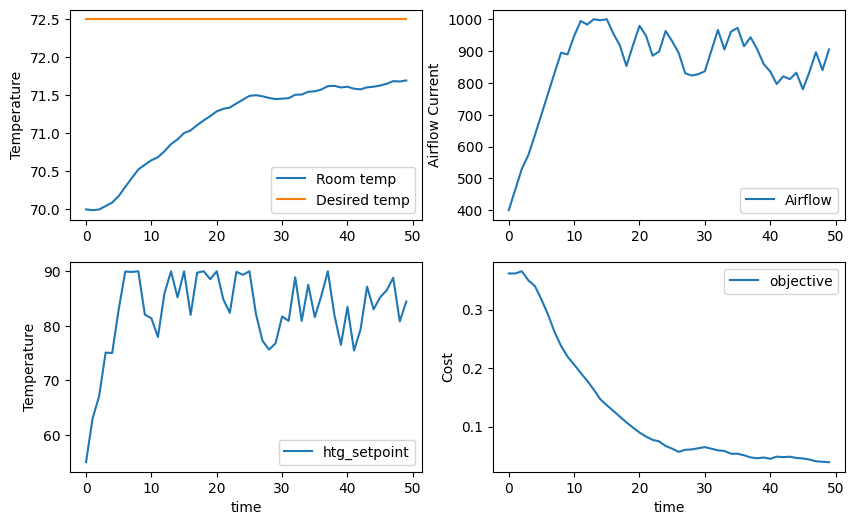

In [121]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx_rev)
plt.plot(t, xxs_rev)
plt.legend(['Room temp', 'Desired temp'])
plt.ylabel('Temperature')

plt.subplot(2, 2, 2)
plt.plot(t, MMs_rev)
plt.legend(['Airflow'])
plt.ylabel('Airflow Current')

plt.subplot(2, 2, 3)
plt.plot(t, TTs_rev)
plt.legend(['htg_setpoint'])
plt.xlabel('time')
plt.ylabel('Temperature')

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])
plt.xlabel('time')
plt.ylabel('Cost')
plt.show()


## 4.3 CasADi + LSTM (PyTorch)

Here, we use the pytorch model for MPC all the codes are similar to the previous section

In [123]:
from casadi import *
from casadi.tools import *
from scipy import linalg, matrix
import pandas as pd

import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

import numpy as np
import time


In [124]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, num_classes) #fully connected 1
        # self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        # out = self.relu(out) #relu
        # out = self.fc(out) #Final Output
        return out

In [125]:
num_epochs = 1000 #100 epochs
learning_rate = 0.001 #0.01 lr

input_size = 3 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [126]:

loaded_lstm = LSTM1(num_classes, input_size, hidden_size, num_layers, input_size)
loaded_lstm.load_state_dict(torch.load("Pytorch_LSTM.pth"))
loaded_lstm.eval()

LSTM1(
  (lstm): LSTM(3, 64, batch_first=True)
  (fc_1): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [127]:
class MyCallback(Callback):
  def __init__(self, name, opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 3
  def get_n_out(self): return 1

  # Initialize the object
  def init(self):
     print('initializing object')

  # Evaluate numerically
  def eval(self, arg):
    T = arg[0]
    Ts = arg[1]
    Ms = arg[2]
    input = np.array([T, Ts, Ms]).astype('float32').reshape(1,-1)
    input_tensor = Variable(torch.Tensor(input)) 
    input_tensor = torch.reshape(input_tensor, (input_tensor.shape[0], 1, input_tensor.shape[1]))
    output = loaded_lstm(input_tensor)
    output = output.detach().numpy()
    return [output]

In [128]:
def normal(x, min, max):
    norm = (x - min)/(max - min)
    return norm

def revnormal(x, min, max):
    norm = (x * (max - min)) + min
    return norm

def normaldelta(x, min, max):
    norm = (x)/(max - min)
    return norm

In [129]:
lstm = MyCallback('lstm', {"enable_fd":True})
T = 70
Ts = 90
Ms = 1000
T = normal(T, scaler.data_min_[0],  scaler.data_max_[0])
Ts = normal(Ts, scaler.data_min_[1],  scaler.data_max_[1])
Ms = normal(Ms, scaler.data_min_[2],  scaler.data_max_[2])

To = revnormal(lstm(T, Ts, Ms), scaler.data_min_[0],  scaler.data_max_[0])
To

initializing object


DM(70.0329)

In [130]:
#######################################
##########  Parameters  ###############
#######################################

N = 3 # Horizon length
runtime = 50
dt = 1;          # Time step
x0 = 70.0        # Initial temperature
xs = 72.5        # Reference Temperature

# Constraints parameters
max_delta_Ts = 8.0
min_delta_Ts = -8.0

max_delta_Ms = 65.0
min_delta_Ms = -65.0

max_Ts = 90.0
min_Ts = 55.0

max_Ms = 1000.0
min_Ms = 400.0

min_Ts_global = 55.0
min_Ms_global = 400.0

# Optimization parameters
obj = 0
a = 1
b = 1e-2
c = 1e-5


# Normalize our data
max_delta_Ts = normaldelta(max_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_delta_Ts = normaldelta(min_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_delta_Ms = normaldelta(max_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_delta_Ms = normaldelta(min_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])


max_Ts = normal(max_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_Ts = normal(min_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_Ms = normal(max_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_Ms = normal(min_Ms, scaler.data_min_[2],  scaler.data_max_[2])

min_Ts_global = min_Ts
min_Ms_global = min_Ms

x0 = normal(x0, scaler.data_min_[0],  scaler.data_max_[0])
xs = normal(xs, scaler.data_min_[0],  scaler.data_max_[0])


#######################################
#######  CasADi optimization   ########
#######################################


#states
states = struct_symMX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symMX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


# Create tructure for the entire horizon
variables = struct_symMX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symMX([entry("x0", shape=(6, 1))])

# NPL for optimization


obj += (parameters["x0", 0] - parameters["x0", 1])**2 + c*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = lstm(parameters["x0", 0], variables["U", 0][0], variables["U", 0][1])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + c*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = lstm(parameters["x0", 0], variables["U", k][0], variables["U", k][1])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)

# define lower and upper bound for constraints
args = {}
upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb


#######################################
##########  MPC simulation  ###########
#######################################

# define empty arrays o store simulation data
t = np.arange(0, runtime, dt)
xxs = np.full((runtime,1), xs)
xx = []
xx.append(x0)
cost = []
TTs = []
TTs.append(min_Ts)
MMs = []
MMs.append(min_Ms)

# The initial guess for optimization
u0 = []
for i in range(N):
  u0 += [min_Ts]
  u0 += [min_Ms]


# simulate
args['x0'] = u0

for i in range(1, runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])


  st_next = lstm(args['p'][0], sol['x'][0], sol['x'][1])
  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  # Use the result of MPC optimization as next
  #  stage optimization initial guess
  args['x0'] = vertcat(sol['x'][2:],sol['x'][:2])
  
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])
cost.insert(0, cost[0])

      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.08 s (  1.69ms)   1.08 s (  1.70ms)       637
       nlp_g  |   2.00ms (  3.14us)   3.49ms (  5.48us)       637
    nlp_grad  |  39.00ms ( 39.00ms)  40.24ms ( 40.24ms)         1
  nlp_grad_f  |   2.40 s ( 23.56ms)   2.40 s ( 23.50ms)       102
   nlp_jac_g  |   3.00ms ( 29.41us)   1.68ms ( 16.47us)       102
       total  |   4.27 s (  4.27 s)   4.27 s (  4.27 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.91 s (  1.74ms)   1.92 s (  1.74ms)      1101
       nlp_g  |   3.00ms (  2.72us)   5.78ms (  5.25us)      1101
    nlp_grad  |  42.00ms ( 42.00ms)  41.66ms ( 41.66ms)         1
  nlp_grad_f  |   2.27 s ( 22.25ms)   2.27 s ( 22.29ms)       102
   nlp_jac_g  |   2.00ms ( 19.61us)   1.59ms ( 15.60us)       102
       total  |   4.80 s (  4.80 s)   4.80 s (  4.80 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

As it is shown, the pytorch tensors are more compatible to the CasADi optimizaiton library and the optimization process is much faster than tensorflow.

In [131]:
# Reverse the normalization
xx_rev = revnormal(np.array(xx), scaler.data_min_[0],  scaler.data_max_[0])
xxs_rev = revnormal(np.array(xxs), scaler.data_min_[0],  scaler.data_max_[0])
TTs_rev = revnormal(np.array(TTs), scaler.data_min_[1],  scaler.data_max_[1])
MMs_rev = revnormal(np.array(MMs), scaler.data_min_[2],  scaler.data_max_[2])

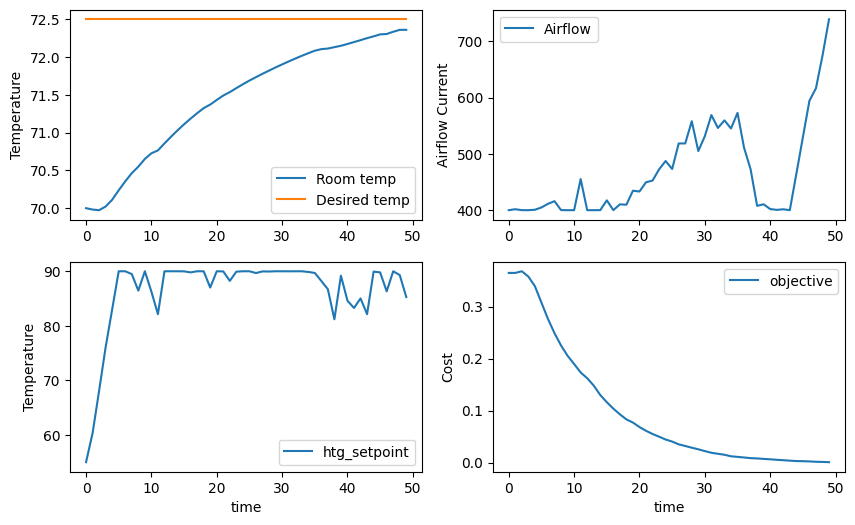

In [132]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx_rev)
plt.plot(t, xxs_rev)
plt.legend(['Room temp', 'Desired temp'])
plt.ylabel('Temperature')

plt.subplot(2, 2, 2)
plt.plot(t, MMs_rev)
plt.legend(['Airflow'])
plt.ylabel('Airflow Current')

plt.subplot(2, 2, 3)
plt.plot(t, TTs_rev)
plt.legend(['htg_setpoint'])
plt.xlabel('time')
plt.ylabel('Temperature')

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])
plt.xlabel('time')
plt.ylabel('Cost')
plt.savefig("myImagePDF3.pdf", format="pdf", bbox_inches="tight") # save fig for post processing
plt.show()


In [ ]:
plt.savefig("myImagePDF.pdf", format="pdf", bbox_inches="tight") # save fig for post processing